In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
import survivors.datasets as ds
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

In [15]:
import survivors.datasets as ds
import warnings
warnings.filterwarnings("ignore")

X, y, features, categ, sch_nan = ds.load_pbc_dataset()

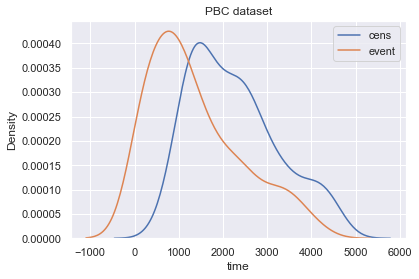

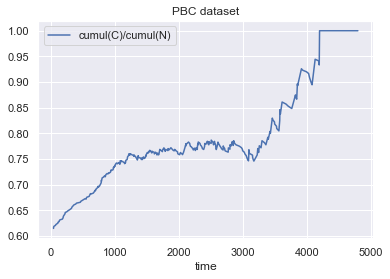

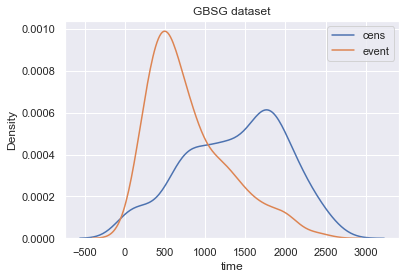

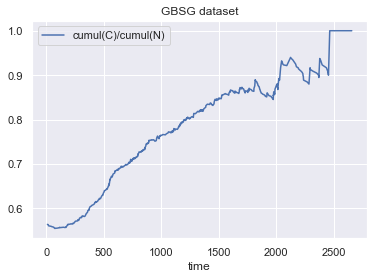

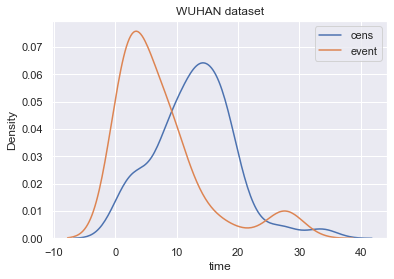

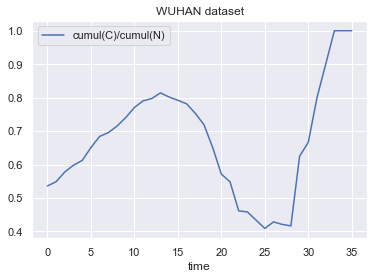

DIAG {'C20': 0, 'C50.4': 1, 'C61': 2}


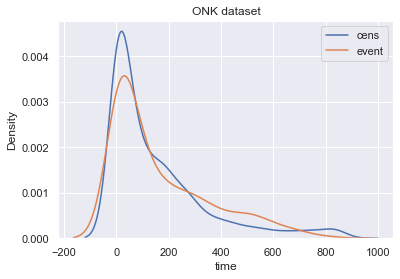

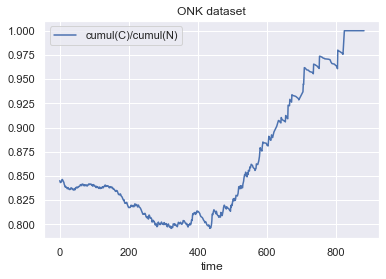

Categ-contin var: has_odyshka_ili_zatrudnennoe_dyhanie
Categ-contin var: has_oschussh_zalozhen_v_grudnoi_kletke
Categ-contin var: has_slabost_ili_lomota
Categ-contin var: Пол
Categ-contin var: PCR_N
Categ-contin var: has_kashel
Categ-contin var: kashel_type
Categorical var: resultat_KT 6


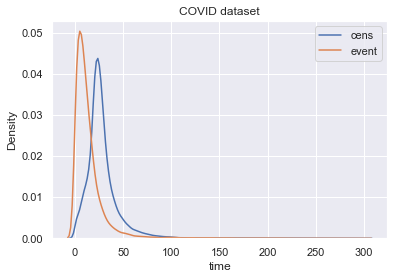

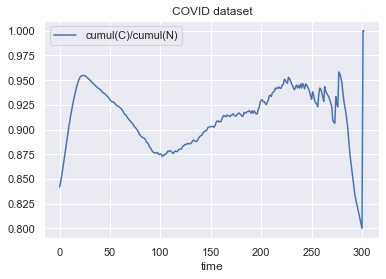

In [31]:
def plot_time_distr(v, label):
    sns.kdeplot(v[~v["cens"]]["time"],label="cens")
    sns.kdeplot(v[v["cens"]]["time"], label="event")
    plt.title(f"{label} dataset")
    plt.xlabel("time")
    plt.legend()
    plt.show()
    
def plot_cens_ratio(v, label):
    time = np.searchsorted(np.unique(v["time"]), v["time"])
    time_hist = np.bincount(time)
    cens_hist = np.bincount(time, weights=1-v["cens"])
    N = np.cumsum(time_hist[::-1])[::-1]
    C = np.cumsum(cens_hist[::-1])[::-1]
    plt.plot(np.unique(v["time"]), C/N, label="cumul(C)/cumul(N)")
    #plt.scatter(np.unique(v["time"]), cens_hist/time_hist, label="C/N")
    plt.title(f"{label} dataset")
    plt.xlabel("time")
    plt.legend()
    plt.show()
    
X, y, features, categ, sch_nan = ds.load_pbc_dataset()
plot_time_distr(y, "PBC")
plot_cens_ratio(y, "PBC")
X, y, features, categ, sch_nan = ds.load_gbsg_dataset()
plot_time_distr(y, "GBSG")
plot_cens_ratio(y, "GBSG")
X, y, features, categ, sch_nan = ds.load_wuhan_dataset()
plot_time_distr(y, "WUHAN")
plot_cens_ratio(y, "WUHAN")
X, y, features, categ, sch_nan = ds.load_onk_dataset()
plot_time_distr(y, "ONK")
plot_cens_ratio(y, "ONK")
X, y, features, categ, sch_nan = ds.load_covid_dataset()
plot_time_distr(y, "COVID")
plot_cens_ratio(y, "COVID")

In [54]:
from survivors.tree import KaplanMeier
    
class ModifKaplanMeier(KaplanMeier):
    def fit(self, durations, right_censor, weights=None):
        if weights is None:
            weights = np.ones(right_censor.shape)
        self.timeline = np.unique(durations)

        dur_ = np.searchsorted(self.timeline, durations)
        
        only_cens = np.bincount(dur_, weights=right_censor*weights)
        self.hist_cens = np.bincount(dur_, weights=weights)
        self.hist_cens -= only_cens
        
        self.cumul_hist_dur = np.cumsum(self.hist_cens[::-1])[::-1]
        self.survival_function = np.hstack([1.0, np.cumprod((1.0 - self.hist_cens / (self.cumul_hist_dur)))])
        
        N = right_censor.shape[0]
        Ncens = right_censor[~right_censor].shape[0]
        self.survival_function = Ncens/N  + (1 - Ncens/N)*self.survival_function

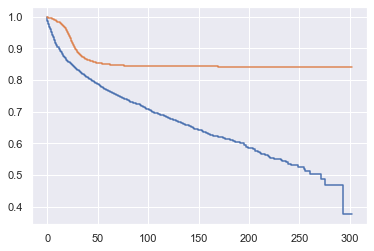

In [55]:
kmf = KaplanMeier()
kmf.fit(y["time"], y["cens"])
plt.step(np.hstack([0, kmf.timeline]), kmf.survival_function)

mkmf = ModifKaplanMeier()
mkmf.fit(y["time"], y["cens"])
plt.step(np.hstack([0, mkmf.timeline]), mkmf.survival_function)
plt.show()

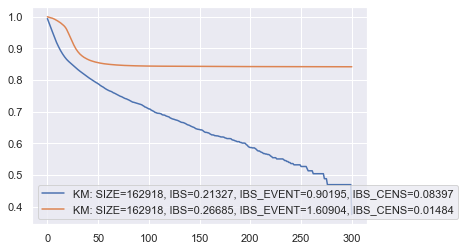

In [56]:
def plot_km_with_ibs(data, label):
    bins = cnt.get_bins(data[cnt.TIME_NAME], 
                        cens=data[cnt.CENS_NAME])
    kmf = KaplanMeier()
    kmf.fit(data[cnt.TIME_NAME], data[cnt.CENS_NAME])
    sf_train = kmf.survival_function_at_times(bins)
    
    pred_sf = np.repeat(sf_train[np.newaxis, :], data.shape[0], axis=0)
    true_sf = cnt.get_y(data[cnt.CENS_NAME], data[cnt.TIME_NAME])
    ibs_val = round(metr.ibs(true_sf, true_sf, pred_sf, bins), 5)
    ibs_events = round(metr.ibs(true_sf, true_sf[true_sf["cens"]], pred_sf[true_sf["cens"]], bins), 5)
    ibs_cens = round(metr.ibs(true_sf, true_sf[~true_sf["cens"]], pred_sf[~true_sf["cens"]], bins), 5)
    plt.plot(bins, sf_train, label=f"KM{label}: SIZE={data.shape[0]}, IBS={ibs_val}, IBS_EVENT={ibs_events}, IBS_CENS={ibs_cens}")
    
    kmf = ModifKaplanMeier()
    kmf.fit(data[cnt.TIME_NAME], data[cnt.CENS_NAME])
    sf_train = kmf.survival_function_at_times(bins)
    
    pred_sf = np.repeat(sf_train[np.newaxis, :], data.shape[0], axis=0)
    true_sf = cnt.get_y(data[cnt.CENS_NAME], data[cnt.TIME_NAME])
    ibs_val = round(metr.ibs(true_sf, true_sf, pred_sf, bins), 5)
    ibs_val = round(metr.ibs(true_sf, true_sf, pred_sf, bins), 5)
    ibs_events = round(metr.ibs(true_sf, true_sf[true_sf["cens"]], pred_sf[true_sf["cens"]], bins), 5)
    ibs_cens = round(metr.ibs(true_sf, true_sf[~true_sf["cens"]], pred_sf[~true_sf["cens"]], bins), 5)
    plt.plot(bins, sf_train, label=f"KM{label}: SIZE={data.shape[0]}, IBS={ibs_val}, IBS_EVENT={ibs_events}, IBS_CENS={ibs_cens}")
    plt.legend()
    plt.show()
    
plot_km_with_ibs(y, "")